# Fine-Tuning BERT for Sentence Pair Identification

In [1]:
# Fine-Tuning BERT for Sentence Pair Classification# checking tenserflow gpu
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# Importing libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import warnings
warnings.filterwarnings("ignore")

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow as tf_keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, precision_score
plt.style.use('ggplot')
os.environ["TOKENIZERS_PARALLELISM"] = "true"


# random.seed(101) # AUC - 
random.seed(111) # AUC - 
# random.seed(113) # AUC - 
# random.seed(911) # AUC - 

%matplotlib inline

plt.rcParams["figure.figsize"] = (8, 6)
plt.style.use("default")

max_length = 192 # Token Length

# Model set and batch size
model_checkpoint = "distilbert-base-uncased"
# model_checkpoint = "bert-base-uncased"

batch_size = 16 # for distilbert
# batch_size = 12 # for bert

batch_size = 24 # for distilbert
num_epochs = 3

In [3]:
# Reading the data
train_fname = "./data/train.csv"
train_fname = "./data/new_train_clean_augmented.csv"
train_df = pd.read_csv(train_fname)
train_df.shape

val_df = pd.read_csv("./data/dev.csv")
val_df.shape

test_df = pd.read_csv("./data/test.csv")
test_df.shape

(5977, 5)

In [4]:
def data_read_clean(df, dfname=None):
    print(df.head())
    print(df.info())
    print(df.isnull().sum())
    print(df.dropna(inplace=True))
    print(df.info())
    print(df.columns)
    if dfname in 'test':
        fname = dfname
        df.drop(['id', 'username', 'timeline_id'], axis=1, inplace=True)
    elif dfname in ['train', 'val']:
        fname = dfname
        df.drop(['id', 'label', 'username', 'timeline_id'], axis=1, inplace=True)
    else:
        fname =dfname.split("_")[0]
    df.to_csv(fname+'_clean.csv',index=False)

print("Processing Train Dataset")
# data_read_clean(train_df, 'train')
data_read_clean(train_df, 'train_aug')
print("Processing Validation Dataset")
data_read_clean(val_df, 'val')
print("Processing Test Dataset")
data_read_clean(test_df, 'test')

Processing Train Dataset
                                               rumor  is_evidence  \
0  Okaz Qatar Airways be an official sponsor of t...            0   
1  Macron to Sky News after my visit to Mrs Fairo...            0   
2  the official spokesman for the Football Associ...            0   
3  dThe Guardian warn of the outbreak of deadly v...            0   
4  the World Health Organization call for stop th...            0   

                                            timeline  
0                          ISSUE could not translate  
1                      Beirut night search for pulse  
2  watch Hussein Al Shahat meet his friend with t...  
3  UNEP open nomination for prestigious Champions...  
4  Tigray UN agency indicate that child be at ris...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42710 entries, 0 to 42709
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rumor        42710 non-null  object

In [5]:
# Printing the first 5 rows
train_df.head()

,rumor,is_evidence,timeline
0,Okaz Qatar Airways be an official sponsor of t...,0,ISSUE could not translate
1,Macron to Sky News after my visit to Mrs Fairo...,0,Beirut night search for pulse
2,the official spokesman for the Football Associ...,0,watch Hussein Al Shahat meet his friend with t...
3,dThe Guardian warn of the outbreak of deadly v...,0,UNEP open nomination for prestigious Champions...
4,the World Health Organization call for stop th...,0,Tigray UN agency indicate that child be at ris...


In [6]:
# Information about dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42702 entries, 0 to 42709
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rumor        42702 non-null  object
 1   is_evidence  42702 non-null  int64 
 2   timeline     42702 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [7]:
# checking for null values
train_df.isnull().sum()

rumor          0
is_evidence    0
timeline       0
dtype: int64

In [8]:
# Removing null values
train_df.dropna(inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42702 entries, 0 to 42709
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rumor        42702 non-null  object
 1   is_evidence  42702 non-null  int64 
 2   timeline     42702 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [9]:
train_df.columns

Index(['rumor', 'is_evidence', 'timeline'], dtype='object')

### Converting data to HuggingFace Dataset

In [10]:
# Convert the data into Hugging Face Dataset format
dataset = load_dataset('csv', data_files={'train': 'train_clean.csv','valid':'val_clean.csv',})
dataset

Generating train split: 42702 examples [00:00, 213305.00 examples/s]
Generating valid split: 4572 examples [00:00, 220852.00 examples/s]


DatasetDict({
    train: Dataset({
        features: ['rumor', 'is_evidence', 'timeline'],
        num_rows: 42702
    })
    valid: Dataset({
        features: ['rumor', 'is_evidence', 'timeline'],
        num_rows: 4572
    })
})

In [11]:
# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Testing Tokenizer

In [12]:
# Running tokenizer on sample data
tokenizer(train_df.rumor[0], train_df.timeline[0],padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')  

{'input_ids': <tf.Tensor: shape=(1, 192), dtype=int32, numpy=
array([[  101,  7929, 10936, 12577, 13095,  2022,  2019,  2880, 10460,
         1997,  1996,  8174,  2632,  2009,  3775, 16102,  2252,   102,
         3277,  2071,  2025, 17637,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

### Tokenizer for data preprocessing

In [13]:
# function to tokenize the data
def preprocess_function(records):
    return tokenizer(records['rumor'], records['timeline'], truncation=True, max_length = max_length)

In [14]:
# Running tokenizer on dataset
encoded_dataset = dataset.map(preprocess_function, batched=True, )

Map: 100%|████████████████████████████████████████████████████████████████| 4572/4572 [00:00<00:00, 5407.33 examples/s]


In [15]:
# Preprocessed dataset
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['rumor', 'is_evidence', 'timeline', 'input_ids', 'attention_mask'],
        num_rows: 42702
    })
    valid: Dataset({
        features: ['rumor', 'is_evidence', 'timeline', 'input_ids', 'attention_mask'],
        num_rows: 4572
    })
})

In [16]:
# Columns added by tokenizer
col_tokenizer = encoded_dataset.column_names['train'][3:]
col_tokenizer

['input_ids', 'attention_mask']

### Data padding and batching

In [17]:
# Adding Padding to the dataset
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf",)

In [18]:
# Making the dataset batched and shuffled
tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=col_tokenizer,
    label_cols=["is_evidence"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["valid"].to_tf_dataset(
    columns=col_tokenizer,
    label_cols=["is_evidence"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [19]:
# sample train batch
sample_batch=next(iter(tf_train_dataset))
sample_batch

({'input_ids': <tf.Tensor: shape=(24, 129), dtype=int64, numpy=
  array([[  101,  8174,  9264, ...,     0,     0,     0],
         [  101,  2266,  1997, ...,     0,     0,     0],
         [  101, 13085,  7523, ...,     0,     0,     0],
         ...,
         [  101,  1996,  2088, ...,     0,     0,     0],
         [  101,  9413, 16168, ...,     0,     0,     0],
         [  101,  8174,  9264, ...,     0,     0,     0]], dtype=int64)>,
  'attention_mask': <tf.Tensor: shape=(24, 129), dtype=int64, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int64)>},
 <tf.Tensor: shape=(24,), dtype=int64, numpy=
 array([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1], dtype=int64)>)

In [20]:
# sample decoded string
tokenizer.decode(sample_batch[0]['input_ids'][0])

'[CLS] saudi arabia evacuate student from china in plane that could accommodate more and do not evacuate yemeni student with it while participate with warplane and bomb yemen may god protect the sultanate of oman for send private plane to the yemeni student strand in china and what good neighbor china unk https co ofdsiodry [SEP] saudi arabia evacuate student from china in plane that could accommodate more and do not evacuate yemeni student with it while participate with warplane and bomb yemen may god protect the sultanate of oman for send private plane to the yemeni student strand in china and what good neighbor china unk https co ofdsiodry [SEP] [PAD] [PAD] [PAD] [PAD]'

In [21]:
# Percentage of classes in dataset
num_classes = len(train_df.is_evidence.unique())
round(train_df.is_evidence.value_counts(normalize=True)*100,2)

is_evidence
0    53.54
1    46.46
Name: proportion, dtype: float64

In [22]:
# HANDLING THE IMBALANCED DATASETS
def compute_class_weight(train_y):
    """
    Compute class weight given imbalanced training data
    Usually used in the neural network model to augment the loss function (weighted loss function)
    Favouring/giving more weights to the rare classes.
    """
    import sklearn.utils.class_weight as scikit_class_weight

    class_list = np.array(list(set(train_y)))
    class_weight_value = scikit_class_weight.compute_class_weight(class_weight ='balanced', classes = class_list, y = train_y)
#     print(class_weight_value)
    class_weight = dict()

    # Initialize all classes in the dictionary with weight 1
    curr_max = int(np.max(class_list))
    for i in range(curr_max):
        class_weight[i] = 1

    # Build the dictionary using the weight obtained the scikit function
    for i in range(len(class_list)):
        class_weight[class_list[i]] = class_weight_value[i]

    return class_weight

balancing_weights = compute_class_weight(train_df['is_evidence'])
weights_val = [x/sum(balancing_weights.values()) for x in balancing_weights.values()]
weights = tf.transpose(tf.cast([weights_val], dtype='float32'))
print(weights)
weights

tf.Tensor(
[[0.4645684]
 [0.5354316]], shape=(2, 1), dtype=float32)


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.4645684],
       [0.5354316]], dtype=float32)>

### Loading the model checkpoint

In [23]:
# Downloading the model
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_classes)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [24]:
# import tensorflow as tf
# from transformers import AutoTokenizer, TFAutoModel

# class CustomBERTModel(tf.keras.Model):
#     def __init__(self):
#         super(CustomBERTModel, self).__init__()
#         self.bert = TFAutoModel.from_pretrained(model_checkpoint)
#         self.linear1 = tf.keras.layers.Dense(512, activation='relu', name='dense_1')
#         self.dropout1 = tf.keras.layers.Dropout(0.3, name='dropout_1')
#         self.linear2 = tf.keras.layers.Dense(256, activation='relu', name='dense_2')
#         self.dropout2 = tf.keras.layers.Dropout(0.3, name='dropout_2')
#         self.softmax_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification')  

#     def call(self, inputs, training=False):
#         ids, mask = inputs
#         sequence_output = self.bert(ids, mask, training=training).last_hidden_state

#         linear1_output = self.linear1(sequence_output[:,0,:])
#         dropout1_output = self.dropout1(linear1_output)
#         linear2_output = self.linear2(dropout1_output)
#         dropout2_output = self.dropout2(linear2_output)
#         softmax_output = self.softmax_output(dropout2_output)

#         return softmax_output


# model = CustomBERTModel()
# # tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# # ipts = tokenizer("Some input sequence", return_tensors="tf")
# # test = model((ipts["input_ids"], ipts["attention_mask"]))

### Defining the parameters, optimizer and loss function

In [25]:
# Setting epochs and learning rate
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps, power = 2
)

### Plotting the learning rate decay

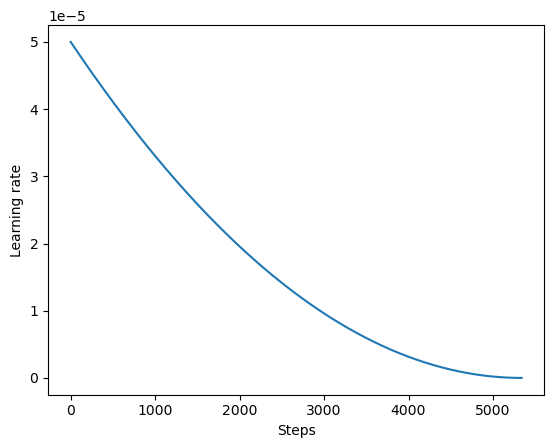

In [26]:
# Plotting the learning rate
plt.plot([lr_scheduler(step).numpy() for step in range(num_train_steps)])
plt.xlabel("Steps")
plt.ylabel("Learning rate")
plt.show()

In [27]:
# weights: tf.cast([[0.01192328,0.98807675]], dtype='float32')

def loss(labels, predictions, weights=tf.transpose(weights), from_logits=True):
#     print(predictions.shape)
#     print(weights.shape)

    example_losses = tf.losses.sparse_categorical_crossentropy(
      labels, predictions, from_logits=from_logits)

    if weights is None:
        return tf.reduce_mean(example_losses)
    weights = tf.cast(weights, predictions.dtype)
    return tf.reduce_mean(example_losses * weights)

# weights = tf.transpose(tf.cast([[0.01192328,0.98807675]], dtype='float32'))
weights

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.4645684],
       [0.5354316]], dtype=float32)>

In [28]:
import tensorflow as tf
from_logits=True

def loss(labels, predictions, weights=weights, from_logits=from_logits):
#     print(predictions.shape)
#     print(weights.shape)

    example_losses = tf.losses.sparse_categorical_crossentropy(
      labels, predictions, from_logits=from_logits)

    if weights is None:
        return tf.reduce_mean(example_losses)
    weights = tf.cast(weights, predictions.dtype)
    return tf.math.divide_no_nan(
      tf.reduce_sum(example_losses * weights), tf.reduce_sum(weights))

# weights = tf.transpose(tf.cast([[0.01192328,0.98807675]], dtype='float32'))
weights

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.4645684],
       [0.5354316]], dtype=float32)>

In [29]:
# Optimizer and loss function
opt = Adam(learning_rate=lr_scheduler)
# loss = SparseCategoricalCrossentropy(from_logits=True)

In [30]:
# Compiling the model
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [31]:
# filepath = './models/evidence_identification_model/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}'
# # earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='min')
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, save_best_only=True, verbose=1, monitor='val_loss', mode='min')
# # reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-4, mode='min')

# # # Training the model
# history=model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs, verbose=1, callbacks=[checkpoint])

In [32]:
print("Batch size: {} & Input Token Length: {}".format(batch_size, max_length))

class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
#         print(logs)
#         print("epoch: ", epoch)
#         print(list(logs.keys()))
#         self.model.save("./classification_model/model_{}.hd5".format(epoch))
        self.model.save_pretrained("./models/evidence_identification_model/model.epoch{:02d}-loss{:.2f}".format(epoch, logs['val_loss']))
            
saver = CustomSaver()
# Training the model
history=model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs, verbose=1, callbacks=[saver])

Batch size: 24 & Input Token Length: 192
Epoch 1/3
1780/1780 [==============================] - 945s 525ms/step - loss: 0.6623 - accuracy: 0.9928 - val_loss: 1.2228 - val_accuracy: 0.9871
Epoch 2/3
1780/1780 [==============================] - 936s 526ms/step - loss: 0.2550 - accuracy: 0.9964 - val_loss: 2.2330 - val_accuracy: 0.9687
Epoch 3/3
1780/1780 [==============================] - 937s 527ms/step - loss: 0.1084 - accuracy: 0.9985 - val_loss: 1.9883 - val_accuracy: 0.9810


In [33]:
# # Saving the model
# model.save_pretrained(f"saved_model_epoch{num_epochs}")

In [34]:
df_dict = pd.DataFrame(history.history)
metric = 'val_loss'
epoch, val_loss = df_dict[df_dict[metric]==min(df_dict[metric])].index[0], df_dict[df_dict[metric]==min(df_dict[metric])]['val_loss'].item()

best_model_saved_path = "./models/evidence_identification_model/model.epoch{:02d}-loss{:.2f}".format(epoch, val_loss)

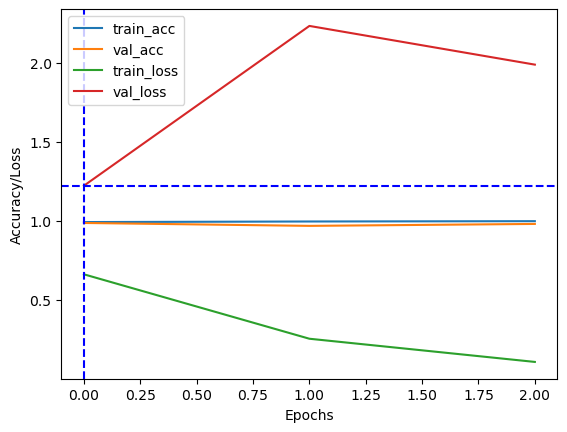

In [35]:
# Plotting the accuracy, training and validation loss 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axhline(y=val_loss, color='b', linestyle='--')
plt.axvline(x=epoch, color='b', linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'])
plt.show()

In [36]:
# Loading the Last saved model
print("Loading Best Model: ", best_model_saved_path)
trained_model = TFAutoModelForSequenceClassification.from_pretrained(best_model_saved_path,num_labels = num_classes)

Loading Best Model:  ./models/evidence_identification_model/model.epoch00-loss1.22


Some layers from the model checkpoint at ./models/evidence_identification_model/model.epoch00-loss1.22 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./models/evidence_identification_model/model.epoch00-loss1.22 and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

In [37]:
# Function to check similarity
def check_similarity(rumor, timeline, debug = 0):
    tokenizer_output = tokenizer(rumor, timeline, truncation=True, max_length = max_length, return_tensors = 'tf')
    logits = trained_model(**tokenizer_output)["logits"]
    tf.nn.softmax(logits, axis=1).numpy()[0][0]
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    if predicted_class_id == 1:
        if(debug):
            print("Timeline Provides Evidence to Rumor")
        return 1
    else:
        if(debug):
            print("Timeline Doesn't Provides Evidence to Rumor")
        return 0

In [38]:
# Checking no evidence between rumor and timeline
rumor = "Avichai Adraee says our battle is with the Muslim Brotherhood. Help us, Arab brothers: Who among you is with them and who among you does not stand with them in their war with Muslims? https://t.co/FlJwpILp6e"
timeline = "Thank you to my friend Samira from Morocco ðŸ‡²ðŸ‡¦ for this special greeting on the occasion of my birthday... I salute you and the hundreds of followers from Morocco who greeted me today. My heartfelt greetings to you https://t.co/5x7HnFvceP"
check_similarity(rumor, timeline, 1)

Timeline Doesn't Provides Evidence to Rumor


0

In [39]:
# Checking evidence between rumor and timeline
rumor = "Vaccination conspiracy? Do we agree that even if there is a question mark, Zain Telecommunications Company #Kuwait has committed a major mistake that must be corrected quickly?!"
timeline = "Vaccination can only be a conspiracy against infection. Let us all conspire against the epidemic in order to return to our old life, which we miss greatly at all levels. Make sense of it and trust... taste. https://t.co/FSYZjbcAqR"
check_similarity(rumor, timeline, 1)

Timeline Doesn't Provides Evidence to Rumor


0

### Testing the model on validation set and test set

In [40]:
import swifter

In [41]:
# checking accuracy on val data
val_df = pd.read_csv("val_clean.csv").sample(1000)
val_df['predicted'] = val_df.swifter.apply(lambda row: check_similarity(row['rumor'], row['timeline']), axis=1)

Pandas Apply: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.67it/s]


In [42]:
# checking metrics on val data
val_df['predicted'] = val_df['predicted'].astype(int)
val_df['is_evidence'] = val_df['is_evidence'].astype(int)
print("Accuracy on Validation data is ",round(accuracy_score(val_df['is_evidence'],val_df['predicted'])*100,2))
print("Precision on Validation data is ",round(precision_score(val_df['is_evidence'],val_df['predicted'])*100,2))
print("Recall on Validation data is ",round(recall_score(val_df['is_evidence'],val_df['predicted'])*100,2))
print("F1 score on Validation data is ",round(f1_score(val_df['is_evidence'],val_df['predicted'])*100,2))
print("ROC AUC score on Validation data is ",round(roc_auc_score(val_df['is_evidence'],val_df['predicted'])*100,2))

Accuracy on Validation data is  98.8
Precision on Validation data is  0.0
Recall on Validation data is  0.0
F1 score on Validation data is  0.0
ROC AUC score on Validation data is  50.0


In [43]:
print(val_df['is_evidence'].value_counts())
print(val_df['predicted'].value_counts())

is_evidence
0    988
1     12
Name: count, dtype: int64
predicted
0    1000
Name: count, dtype: int64


In [44]:
# # checking accuracy on test data
# test_df = pd.read_csv("test_clean.csv").sample(1000)
# test_df['predicted'] = test_df.swifter.apply(lambda row: check_similarity(row['rumor'], row['timeline']), axis=1)

In [45]:
# # checking metrics on test data
# test_df['predicted'] = test_df['predicted'].astype(int)
# test_df['is_evidence'] = test_df['is_evidence'].astype(int)
# print("Accuracy on test data is ",round(accuracy_score(test_df['is_evidence'],test_df['predicted'])*100,2))
# print("Precision on test data is ",round(precision_score(test_df['is_evidence'],test_df['predicted'])*100,2))
# print("Recall on test data is ",round(recall_score(test_df['is_evidence'],test_df['predicted'])*100,2))
# print("F1 score on test data is ",round(f1_score(test_df['is_evidence'],test_df['predicted'])*100,2))
# print("ROC AUC score on test data is ",round(roc_auc_score(test_df['is_evidence'],test_df['predicted'])*100,2))

In [46]:
# Function to check similarity
def predict_proba(rumor, timeline, debug = 0):
    tokenizer_output = tokenizer(rumor, timeline, truncation=True, max_length = max_length, return_tensors = 'tf', padding=True)
    logits = trained_model(**tokenizer_output)["logits"]
    predicted_proba_class_id = tf.nn.softmax(logits, axis=1).numpy()[0][1]
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    if predicted_class_id == 1:
        if(debug):
            print("Timeline Provides Evidence to Rumor")
    else:
        if(debug):
            print("Timeline Doesn't Provides Evidence to Rumor")
    return predicted_proba_class_id

In [47]:
# checking accuracy on val data
val_df = pd.read_csv("val_clean.csv")
val_df['predicted'] = val_df.swifter.apply(lambda row: predict_proba(row['rumor'], row['timeline']), axis=1)

Pandas Apply: 100%|████████████████████████████████████████████████████████████████| 4572/4572 [06:31<00:00, 11.68it/s]


In [48]:
val_df

,rumor,is_evidence,timeline,predicted
0,naturalization decree in preparation lebanese ...,0,today the President of the Republic General Mi...,0.000813
1,naturalization decree in preparation lebanese ...,0,President Aoun receive the Minister of Foreign...,0.000960
2,naturalization decree in preparation lebanese ...,0,President Aoun receive the new british Ambassa...,0.001180
3,naturalization decree in preparation lebanese ...,1,aThe Information Office of the Presidency of t...,0.339464
4,naturalization decree in preparation lebanese ...,0,President Aoun receive the lebanese Ambassador...,0.001183
...,...,...,...,...
4567,under the directive of Haitham bin Tariq Al Sa...,0,as National Sports Day approach the State of Q...,0.001028
4568,under the directive of Haitham bin Tariq Al Sa...,0,Education City Stadium will be open in with ca...,0.001180
4569,under the directive of Haitham bin Tariq Al Sa...,0,RT Al ThumamaStadium it be kilometer south of ...,0.001352
4570,under the directive of Haitham bin Tariq Al Sa...,0,RT we congratulate the member of the new youth...,0.001198


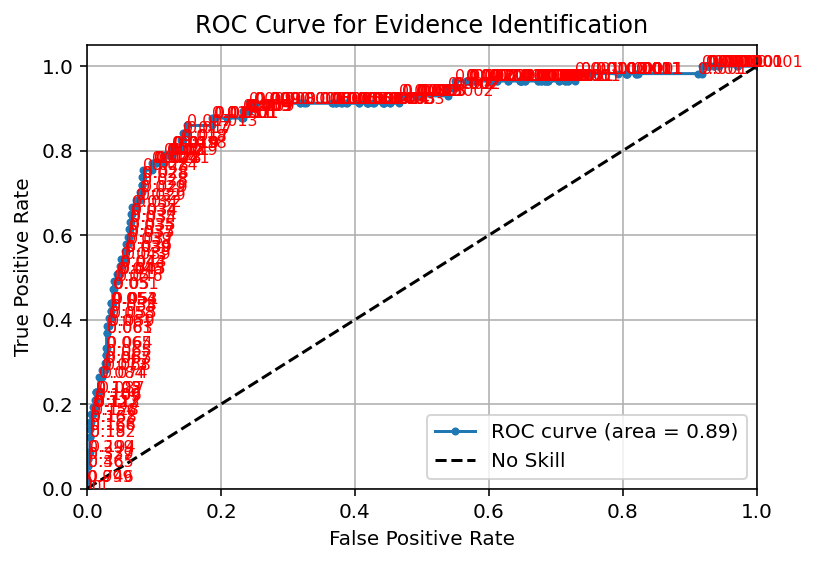

In [49]:
import matplotlib.pyplot as plt

y_test = val_df['is_evidence']
y_pred_proba = val_df['predicted']


from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
fig = plt.figure(figsize=(6,4),dpi=144)
ax = fig.add_subplot(111)
plt.plot(fpr, tpr, marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
for w,xx,yy in zip(thresholds,fpr,tpr):
        ax.annotate(round(w,3), xy=(xx,yy), fontsize=8, color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Evidence Identification')
plt.grid()
plt.legend()
plt.show()

In [50]:
val_df

,rumor,is_evidence,timeline,predicted
0,naturalization decree in preparation lebanese ...,0,today the President of the Republic General Mi...,0.000813
1,naturalization decree in preparation lebanese ...,0,President Aoun receive the Minister of Foreign...,0.000960
2,naturalization decree in preparation lebanese ...,0,President Aoun receive the new british Ambassa...,0.001180
3,naturalization decree in preparation lebanese ...,1,aThe Information Office of the Presidency of t...,0.339464
4,naturalization decree in preparation lebanese ...,0,President Aoun receive the lebanese Ambassador...,0.001183
...,...,...,...,...
4567,under the directive of Haitham bin Tariq Al Sa...,0,as National Sports Day approach the State of Q...,0.001028
4568,under the directive of Haitham bin Tariq Al Sa...,0,Education City Stadium will be open in with ca...,0.001180
4569,under the directive of Haitham bin Tariq Al Sa...,0,RT Al ThumamaStadium it be kilometer south of ...,0.001352
4570,under the directive of Haitham bin Tariq Al Sa...,0,RT we congratulate the member of the new youth...,0.001198


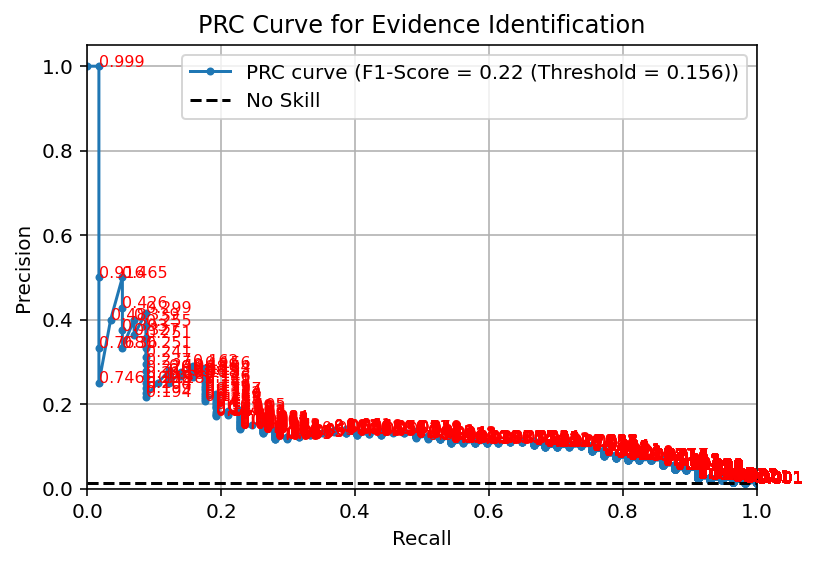

In [51]:
# threshold = 0.887

from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
# Calculate PRC curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba) 

numerator = 2 * recall * precision
denom = recall + precision
f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
max_f1 = np.max(f1_scores)
threshold = thresholds[np.argmax(f1_scores)] # MAX F1 THRESHOLD

y_pred = [1 if i>=threshold else 0 for i in y_pred_proba]
f1score = f1_score(y_test, y_pred)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
fig = plt.figure(figsize=(6,4),dpi=144)
ax = fig.add_subplot(111)
plt.plot(recall, precision, marker='.', label='PRC curve (F1-Score = %0.2f (Threshold = %0.3f))' % (f1score, threshold))
plt.plot([0, 1], [no_skill, no_skill], 'k--', label='No Skill')
for w,xx,yy in zip(thresholds, recall, precision):
        ax.annotate(round(w,3), xy=(xx,yy), fontsize=8, color='red')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PRC Curve for Evidence Identification')
plt.grid()
plt.legend()
plt.show()

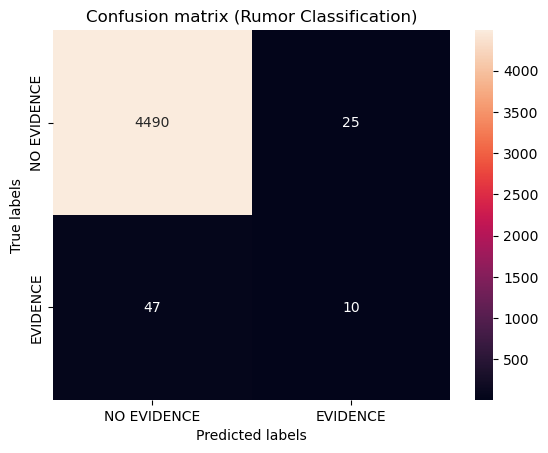

In [52]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion matrix (Rumor Classification)'); 
ax.xaxis.set_ticklabels(['NO EVIDENCE', 'EVIDENCE']); ax.yaxis.set_ticklabels(['NO EVIDENCE', 'EVIDENCE']);